In [1]:
%reload_ext tensorboard
%reload_ext autoreload

# Flow-based Variational Autoencoders

In [2]:
import os
import time
import math
import torch
import numpy as np
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
import torch.distributions as tdist
import torchdyn.nn.node_layers as tdnl

from joblib import dump, load
from sklearn.decomposition import PCA
from pdmtut.core import GenerativeModel
from pytorch_lightning import loggers as pl_loggers
from regilib.core.distributions import MultivariateNormal
from regilib.core.dynamics.dynamics import RegularisedDynamics
from regilib.core.dynamics.dynamical_state import DynamicalState
from regilib.core.invertible_modules import NormalisingFlow
from regilib.core.invertible_modules.bijective import ContinuousAmbientFlow
from regilib.core.invertible_modules.stochastic import VAE

In [3]:
store_results = True
load_models = True

## Introduction

## Implementation

In [4]:
class FlowVAE(NormalisingFlow, pl.LightningModule, GenerativeModel):
    class Encoder(nn.Module):
        """Encoder q(z|x)"""
        
        def __init__(self):
            super().__init__()
            self.dec1 = nn.Linear(3, 64)
            self.decbn1 = nn.BatchNorm1d(num_features=64)
            self.dec2 = nn.Linear(64, 128)
            self.decbn2 = nn.BatchNorm1d(num_features=128)
            self.dec3 = nn.Linear(128, 128)
            self.decbn3 = nn.BatchNorm1d(num_features=128)
            
            # μ
            self.mu_dec4 = nn.Linear(128, 64)
            self.mu_dec5 = nn.Linear(64, 2)
            
            # log σ
            self.log_var_dec4 = nn.Linear(128, 64)
            self.log_var_dec5 = nn.Linear(64, 2)

        def forward(self, x, sample):
            x = F.elu(self.decbn1(self.dec1(x)))
            x = F.elu(self.decbn2(self.dec2(x)))
            x = F.elu(self.decbn3(self.dec3(x)))
            
            # μ
            mu = F.elu(self.mu_dec4(x))
            mu = self.mu_dec5(mu)

            # log σ
            log_var = F.elu(self.log_var_dec4(x))
            log_var = self.log_var_dec5(log_var)
            
            dist = tdist.Normal(mu, torch.exp(log_var/2))
            
            if not sample: z = mu
            else: z = dist.rsample()

            log_qz = dist.log_prob(z).sum(-1)

            return log_qz, z

    class Decoder(nn.Module):
        """Decoder p(x|z)"""
        
        def __init__(self, noise_std):
            super().__init__()
            self.error_dist = MultivariateNormal(
                torch.tensor([0., 0., 0.]), noise_std * torch.eye(3, 3))

            self.dec1 = nn.Linear(2, 64)
            self.decbn1 = nn.BatchNorm1d(num_features=64)
            self.dec2 = nn.Linear(64, 128)
            self.decbn2 = nn.BatchNorm1d(num_features=128)
            self.dec3 = nn.Linear(128, 128)
            self.decbn3 = nn.BatchNorm1d(num_features=128)
            self.dec4 = nn.Linear(128, 64)
            self.dec5 = nn.Linear(64, 3)

        def forward(self, z, context):          
            x = F.elu(self.decbn1(self.dec1(z)))
            x = F.elu(self.decbn2(self.dec2(x)))
            x = F.elu(self.decbn3(self.dec3(x)))
            x = F.elu(self.dec4(x))
            x = self.dec5(x)
            
            if context is None: return x

            log_px = self.error_dist.log_prob(x - context)
            return log_px, x
    
    class FunctionDynamics(nn.Module):
        def __init__(self):
            super().__init__()
            self._in_channels = 3
            self._out_channels = 3
            
            # expected format: N x (C * L)
            # +1 for time
            self.fc1 = nn.Linear(self._in_channels + 1, 128)
            self.fc2 = nn.Linear(128, 256)
            self.fc3 = nn.Linear(256, 256)
            self.fc4 = nn.Linear(256, 128)
            self.fc5 = nn.Linear(128, self._out_channels)  
        
        @property
        def in_channels(self):
            return self._in_channels

        @property
        def out_channels(self):
            return self._out_channels

        def forward(self, ds):
            x = torch.cat([ds.state, ds.t], -1)
            x = F.tanh(self.fc1(x))
            x = F.tanh(self.fc2(x))
            x = F.tanh(self.fc3(x))
            x = F.tanh(self.fc4(x))
            x = self.fc5(x)
            return x
        
    def __init__(self, noise_std, input_dimensions = 3):
        super().__init__(
            base_distribution=MultivariateNormal(torch.zeros(2), torch.eye(2)))
        
        self.input_dimensions = input_dimensions
        
        # state=[l, e, n | state]
        self.vae1 = VAE(FlowVAE.Encoder(), FlowVAE.Decoder(noise_std=noise_std))
        self.aug1 = tdnl.Augmenter(augment_dims=3)
        self.af1 = ContinuousAmbientFlow(
            dynamics=RegularisedDynamics(fdyn=FlowVAE.FunctionDynamics()),
            sensitivity='autograd', default_n_steps=5
        )
 

    # Region NormalisingFlow
    def forward(self, x, ds_context=None, af_estimate=True, vae_sample=False):
        ds = x.clone() if isinstance(x, DynamicalState) else DynamicalState(state=x)
        
        ds = super().forward(ds)
        # TODO: check how we can compute the log prob in forward direction
        ds = self.vae1.forward(ds, sample=vae_sample, ds_context=ds_context)
        ds = self.af1.dynamics.update_ds(ds, self.aug1(ds['state']))
        ds = self.af1.forward(ds, estimate_trace=af_estimate)
        return ds

    def inverse(self, x, af_estimate=True, vae_sample=False):
        ds = x.clone() if isinstance(x, DynamicalState) else DynamicalState(state=x)
        
        ds = self.af1.dynamics.update_ds(ds, self.aug1(ds['state']))
        ds = self.af1.inverse(ds, estimate_trace=af_estimate)
        ds = self.vae1.inverse(ds, sample=vae_sample)

        ds = super().inverse(ds)
        return ds
    
    # Region GenerativeModel
    def encode(self, X):
        ds = self.inverse(X)
        return ds['state'].cpu().detach()

    def decode(self, z):
        ds = self.forward(z)
        return ds['state'].cpu().detach()
    
    def save(self, path):
        torch.save(self, os.path.join(path, 'model.pt'))
    
    def load(path):
        return torch.load(os.path.join(path, 'model.pt'))
            
    def save_exists(path):
        return (
            os.path.isfile(os.path.join(path, 'model.pt')))

    def log_likelihood(self, x):
        ds_z = self.inverse(x, af_estimate=False)
        return ds_z.log_prob.cpu().detach()

    def sample_posterior(self, n_samples):
        ds = super().sample_posterior(n_samples)
        return ds['state'].detach().cpu()
    
    def fit_model(self, X, X_val=None, path=None):
        start_time = time.time()
        
        if path is None:
            tb_logger = False
            checkpoint_callback=False
        else:
            tb_logger = pl_loggers.TensorBoardLogger(path, version=0)
            checkpoint_callback=True
        
        trainer = pl.Trainer(
            max_epochs=2000, gpus=1, logger=tb_logger,
            checkpoint_callback=checkpoint_callback
        )
        trainer.fit(
            self, train_dataloaders=X, val_dataloaders=X_val)
        elapsed_time = time.time() - start_time
        
        if path is not None: 
            with open(os.path.join(path, 'training_time.txt'), 'w') as f:
                f.write(str(elapsed_time))

    def training_step(self, batch, batch_idx):
        x = batch[0]
        lambda_e, lambda_n = 0.01, 0.01
        
        # logp(z_t1) = logp(z_t0) - \int_0^1 - Tr ∂f/∂z(t)
        ds_z = self.inverse(x, af_estimate=True, vae_sample=True)

        # minimise negative log likelihood and energy
        loss = (-ds_z.log_prob + lambda_e * ds_z.e[:, 0] + lambda_n * ds_z.n[:, 0]
        ).sum() / (x.shape[0]*x.shape[1])

        self.log('train_loss', loss)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x = batch[0]
        lambda_e, lambda_n = 0.01, 0.01
        
        # logp(z_t1) = logp(z_t0) - \int_0^1 - Tr ∂f/∂z(t)
        ds_z = self.inverse(x, af_estimate=True, vae_sample=True)

        # minimise negative log likelihood and energy
        loss = (-ds_z.log_prob + lambda_e * ds_z.e[:, 0] + lambda_n * ds_z.n[:, 0]
        ).sum() / (x.shape[0]*x.shape[1])

        self.log('validation_loss', loss)
        return {'val_loss': loss}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return {
            'optimizer': optimizer,
            'lr_scheduler':
            torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, min_lr=1e-8, factor=0.5, verbose=True,
                patience=100
            ), 'monitor': 'train_loss'
        }


    def __str__(self):
        return 'fvae'


## Experiment 1: swiss roll

In [5]:
import pyvista as pv
from pdmtut.datasets import SwissRoll

In [6]:
pv.set_plot_theme("document")

model_save_path = '../results/swiss_roll/fvae'

if store_results:
    result_save_path = '../results/swiss_roll/fvae'
    pv.set_jupyter_backend('None')
else:
    pv.set_jupyter_backend('ipygany')
    result_save_path = None

In [7]:
dataset = SwissRoll(n_samples=100**2, seed=11)

if load_models and FlowVAE.save_exists(model_save_path):
    model = FlowVAE.load(model_save_path)
else:
    model = FlowVAE(noise_std=1e-4)
    model.fit_model(
        X=dataset.train_loader(batch_size=128),
        X_val=dataset.validation_loader(batch_size=128),
        path=result_save_path)
    
    if store_results:
        model.save(model_save_path)
        
model = model.eval()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                  | Params
------------------------------------------------------------
0 | base_distribution | MultivariateNormal    | 0     
1 | vae1              | VAE                   | 76.6 K
2 | aug1              | Augmenter             | 0     
3 | af1               | ContinuousAmbientFlow | 132 K 
------------------------------------------------------------
209 K     Trainable params
0         Non-trainable params
209 K     Total params
0.837     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/bawaw/.conda/envs/pdm_tutorial/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 7.79 GiB total capacity; 6.19 GiB already allocated; 21.12 MiB free; 6.19 GiB reserved in total by PyTorch)

In [8]:
%tensorboard --logdir ../results/swiss_roll/fvae

### Input Representation

In [9]:
from pdmtut.vis import plot_representation

In [10]:
z = model.encode(dataset.X)
z_extremes = model.encode(dataset.y_extremes)

/home/bawaw/.conda/envs/pdm_tutorial/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


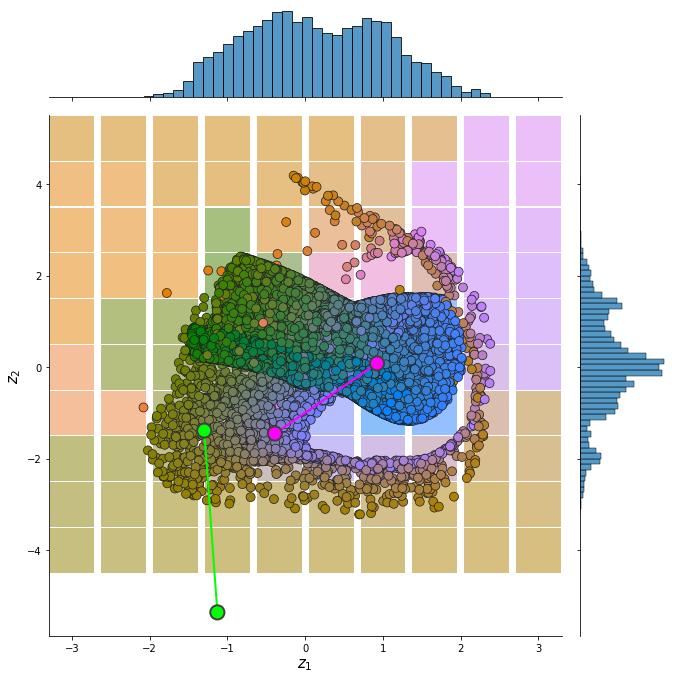

In [11]:
plot_representation(z.numpy(), index_colors=dataset.index_colors, z_extremes=z_extremes, interpolate_background=True, root=result_save_path)

### Input Reconstruction

In [26]:
from pdmtut.vis import plot_reconstruction

In [27]:
z = model.encode(dataset.X)
x = model.decode(z)

/home/bawaw/.conda/envs/pdm_tutorial/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


KeyboardInterrupt: 

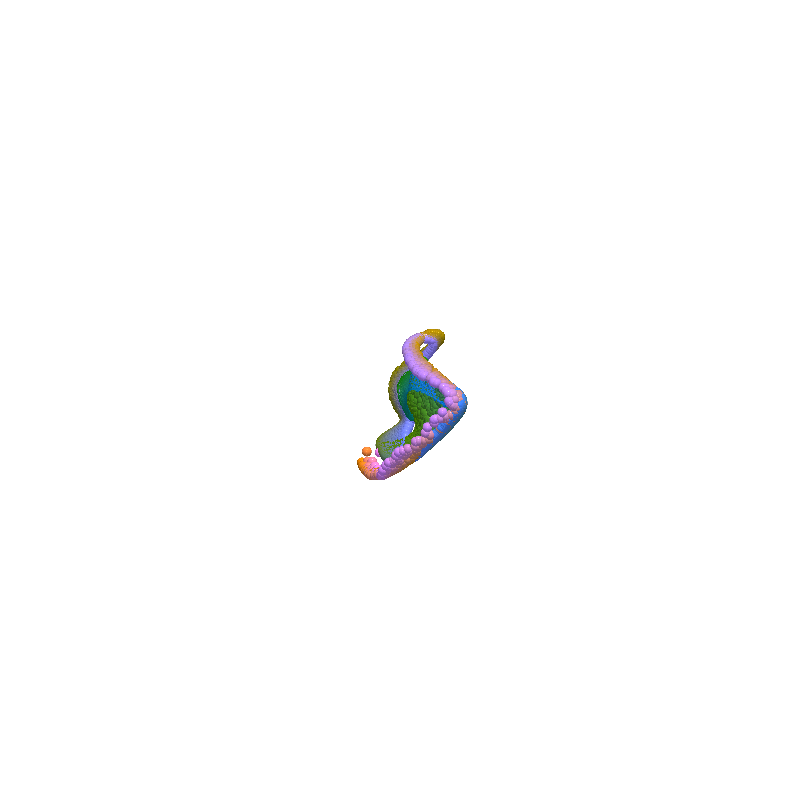

In [14]:
plot_reconstruction(dataset.unnormalise_scale(x).numpy(), dataset.index_colors, root=result_save_path)

### Density Estimation

In [12]:
from pdmtut.vis import plot_density

In [13]:
log_likelihood = model.log_likelihood(dataset.X)

/home/bawaw/.conda/envs/pdm_tutorial/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


KeyboardInterrupt: 

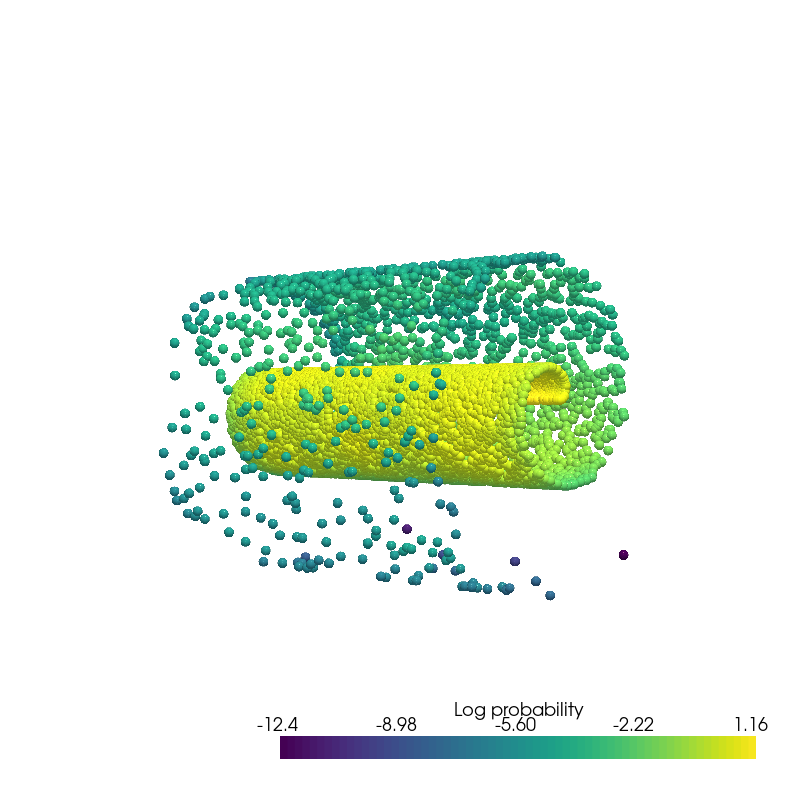

In [17]:
plot_density(dataset.unnormalise_scale(dataset.X).numpy(), log_likelihood.numpy(), root=result_save_path)

### Generate Samples

In [14]:
from pdmtut.vis import plot_generated_samples

In [15]:
generated_samples = model.sample_posterior(100**2)
#generated_samples_log_likelihood = model.log_likelihood(generated_samples)
generated_samples_log_likelihood=torch.zeros(generated_samples.shape[0])

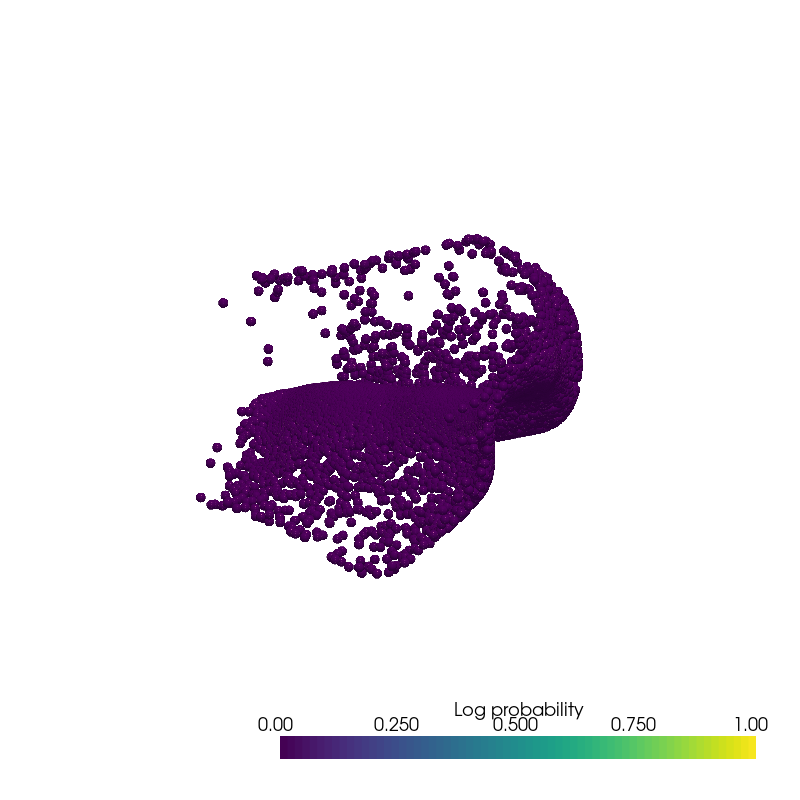

In [16]:
plot_generated_samples(dataset.unnormalise_scale(generated_samples).numpy(), generated_samples_log_likelihood.numpy(), root=result_save_path)

### Interpolation

In [21]:
from pdmtut.vis import plot_interpolation
from scipy.interpolate import interp1d

In [22]:
z_extremes = model.encode(dataset.y_extremes)
uniform_state, uniform_log_prob, _ = dataset.sample_points_uniformly(n_samples=100**2, seed=11)

linfit1 = interp1d([1,20], z_extremes[:2].numpy(), axis=0)
linfit2 = interp1d([1,20], z_extremes[2:].numpy(), axis=0)

interpolated_points_1 = model.decode(torch.Tensor(linfit1(np.arange(1,21))))
interpolated_points_2 = model.decode(torch.Tensor(linfit2(np.arange(1,21))))

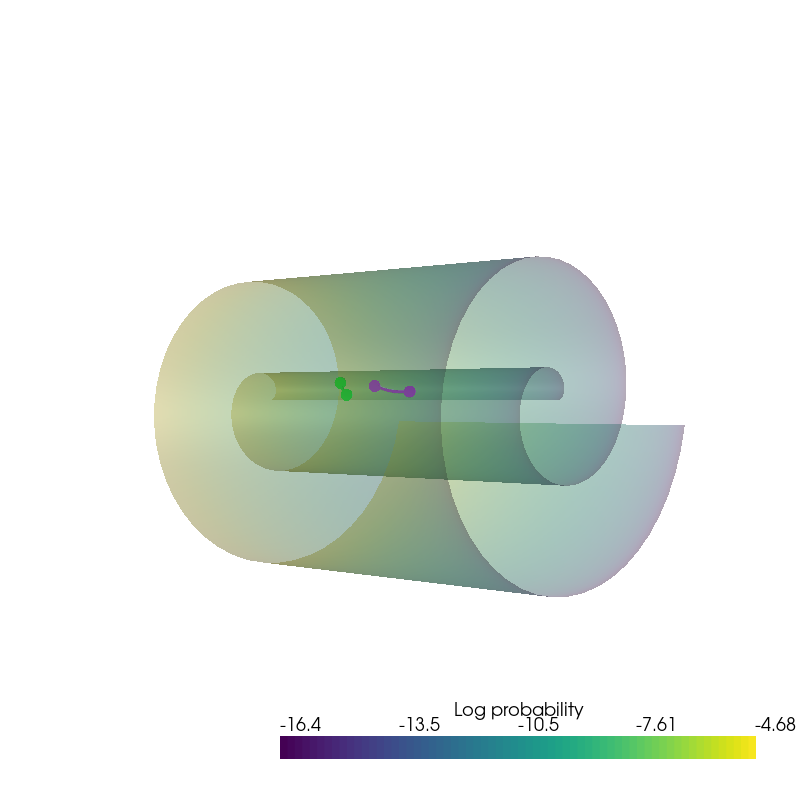

In [23]:
plot_interpolation(
    dataset.unnormalise_scale(interpolated_points_1).numpy(), 
    dataset.unnormalise_scale(interpolated_points_2).numpy(), 
    uniform_state.detach().view(100, 100, 3).permute(2, 0, 1).numpy(),
    uniform_log_prob.numpy(), root=result_save_path
)